In [2]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16100)
<class 'numpy.ndarray'> (3187, 16100)
LOADING MODEL - EXACT TRAINING SCRIPT SEQUENCE

1. Loading checkpoint from: /home/christianl/Zhang-Lab/Zhang Lab Data/Saved models/RNN/uncentered_data_RNN/signaling_model.v1.pt

2. Loading network from: /home/christianl/Zhang-Lab/Zhang Lab Data/Full data files/network(full).tsv
   Network shape: (1153904, 3)
   Network columns: ['TF', 'Gene', 'Interaction']

3. Formatting network...

4. Using EXACT benchmark.py parameters
   projection_amplitude_in: 1.2
   projection_amplitude_out: 1.2
   bionet_params: {'target_steps': 150, 'max_steps': 10, 'exp_factor': 50, 'tolerance': 1e-20, 'leak': 0.01}

5. Initializing model with DataFrames...
   Input X_in shape: (3187, 1197)
   Input y_out shape: (3187, 16100)
  Filtered X_in: 1197 → 1197 features
  Filtered y_out: 16100 → 16100 features
   ✓ Model initialized (data automatically filtered)

6. Converting DataFrames to tensors...
   ✓ Tensors created

7. Applying traini

In [6]:
# helper function for a single Bland-Altman analysis
def bland_altman_plot(data1, data2, ax, model1_name, model2_name, confidence_interval=1.96):
    """
    Helper function to create a single Bland-Altman table on given axis.
    
    Parameters
    ----------
    data1, data2 : array-like
        Predictions from two models (should be same shape)
    ax : matplotlib axis
        Axis to plot on
    model1_name, model2_name : str
        Names of models being compared
    confidence_interval : float
        Z-score for confidence interval (default 1.96 for 95% CI)
    
    Returns
    -------
    dict : Statistics including mean difference, SD, and limits
    """
    # flattening
    data1 = np.asarray(data1).ravel()
    data2 = np.asarray(data2).ravel()
    
    # checking shape matches
    if data1.shape != data2.shape:
        raise ValueError(f"Data shapes don't match: {data1.shape} vs {data2.shape}")
    
    # compute mean and difference
    mean = (data1 + data2) / 2  # This is correct!
    diff = data1 - data2
    
    # basic stats
    md = np.mean(diff)  # Mean difference
    sd = np.std(diff, ddof=1)  # Standard deviation (use ddof=1 for sample SD)
    
    # defining limits of agreement (typically ±1.96 SD for 95% CI)
    ci_low = md - confidence_interval * sd
    ci_high = md + confidence_interval * sd
    
    # scattor plot (sampling as working with large dataset)
    n_points = len(mean)
    if n_points > 50000:
        sample_size = 50000
        indices = np.random.choice(n_points, sample_size, replace=False)
        mean_plot = mean[indices]
        diff_plot = diff[indices]
        alpha = 0.3
    else:
        mean_plot = mean
        diff_plot = diff
        alpha = 0.5
    
    ax.scatter(mean_plot, diff_plot, alpha=alpha, s=20, 
               color='steelblue', edgecolors='none')
    
    # mean difference line
    ax.axhline(md, color='red', linestyle='-', lw=2.5, 
               label=f'Mean diff: {md:.4f}')
    
    # zero line (perfect agreement)
    ax.axhline(0, color='black', linestyle='--', lw=1.5, alpha=0.5,
               label='Perfect agreement')
    
    # limits of agreement (confidence interval lines)
    ax.axhline(ci_high, color='gray', linestyle='--', lw=2, alpha=0.7,
               label=f'±{confidence_interval}σ limits')
    ax.axhline(ci_low, color='gray', linestyle='--', lw=2, alpha=0.7)
    
    # compute percentage of points within limits
    within_limits = np.sum((diff >= ci_low) & (diff <= ci_high))
    pct_within = 100 * within_limits / len(diff)
    
    # text annotations for limits
    x_pos = mean.max() * 0.98
    ax.text(x_pos, ci_high, f'+{confidence_interval}σ: {ci_high:.4f}',
           fontsize=9, verticalalignment='bottom', horizontalalignment='right',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax.text(x_pos, ci_low, f'-{confidence_interval}σ: {ci_low:.4f}',
           fontsize=9, verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # stats box
    textstr = (f'Mean diff: {md:.4f}\n'
               f'SD: {sd:.4f}\n'
               f'Within limits: {pct_within:.1f}%')
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',   # changed to bottom for reference          
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # checking for proportional bias (correlation between mean and difference)
    corr, p_value = pearsonr(mean, diff)
    if abs(corr) > 0.1 and p_value < 0.05:
        # Add trend line to show proportional bias
        z = np.polyfit(mean, diff, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(mean.min(), mean.max(), 100)
        y_trend = p(x_trend)
        ax.plot(x_trend, y_trend, 'r--', lw=1.5, alpha=0.5,
               label=f'Trend (r={corr:.3f})')
        
        # warning test about proportional bias
        if abs(corr) > 0.3:
            ax.text(0.98, 0.02, '⚠ Proportional bias detected', 
                   transform=ax.transAxes,
                   fontsize=9, verticalalignment='bottom', 
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='orange', alpha=0.8))
    
    # labels and formatting
    ax.set_xlabel(f'Mean of {model1_name} & {model2_name}', 
                  fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Difference ({model1_name} - {model2_name})', 
                  fontsize=11, fontweight='bold')
    ax.set_title(f'{model1_name} vs {model2_name}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='lower left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # summary stats
    return {
        'mean_diff': md,
        'sd': sd,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'pct_within_limits': pct_within,
        'proportional_bias_r': corr,
        'proportional_bias_p': p_value
    }


def figure_3_bland_altman(predictions_dict, 
                         output_path='/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures/Fig3'):
    """
    Generate Bland-Altman plots for pairwise model comparisons.
    
    Parameters
    ----------
    predictions_dict : dict
        Dictionary of predictions by model
        Example: {'MLR': pred_mlr, 'XGBRFRegressor': pred_xgbrf, 'RNN': pred_rnn}
    output_path : str
        Path to save figure
    
    Returns
    -------
    dict : Statistics for each comparison
    """
    set_publication_style()
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    
    if n_models < 2:
        raise ValueError("Need at least 2 models for comparison")
    
    # all pairwise comparisons
    from itertools import combinations
    comparisons = list(combinations(model_names, 2))
    n_comparisons = len(comparisons)
    
    print(f"\nGenerating {n_comparisons} Bland-Altman plots for pairwise comparisons...")
    
    # subplot layout
    if n_comparisons == 1:
        fig, axes = plt.subplots(1, 1, figsize=FIGSIZE_SINGLE)
        axes = [axes]
    elif n_comparisons == 2:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    elif n_comparisons == 3:
        fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    elif n_comparisons == 4:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
    elif n_comparisons <= 6:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.ravel()
    else:
        # For more than 6 comparisons, create a grid
        n_cols = 3
        n_rows = (n_comparisons + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
        axes = axes.ravel()
    
    # generate plots
    statistics = {}
    
    for idx, (model1, model2) in enumerate(comparisons):
        ax = axes[idx]
        print(f"  Comparing {model1} vs {model2}...")
        
        stats = bland_altman_plot(
            predictions_dict[model1],
            predictions_dict[model2],
            ax, model1, model2
        )
        
        statistics[f'{model1}_vs_{model2}'] = stats
    
    # hide unused subplots
    for idx in range(n_comparisons, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"\nFigure 3 saved to {output_path}")
    plt.show()
    
    # summary stats
    print("\n" + "="*80)
    print("BLAND-ALTMAN COMPARISON SUMMARY")
    print("="*80)
    
    for comparison, stats in statistics.items():
        print(f"\n{comparison}:")
        print(f"  Mean difference: {stats['mean_diff']:8.4f}")
        print(f"  SD of difference: {stats['sd']:7.4f}")
        print(f"  95% limits: [{stats['ci_low']:7.4f}, {stats['ci_high']:7.4f}]")
        print(f"  Within limits: {stats['pct_within_limits']:5.1f}%")
        
        if abs(stats['proportional_bias_r']) > 0.1 and stats['proportional_bias_p'] < 0.05:
            print(f"  ⚠ Proportional bias: r={stats['proportional_bias_r']:.3f}, p={stats['proportional_bias_p']:.2e}")
        
        # interpretation
        if abs(stats['mean_diff']) < 0.01:
            print("  → Models show excellent agreement (negligible bias)")
        elif abs(stats['mean_diff']) < 0.1:
            print("  → Models show good agreement (minor bias)")
        else:
            print("  → Models show systematic difference")
    
    print("="*80 + "\n")
    
    return statistics


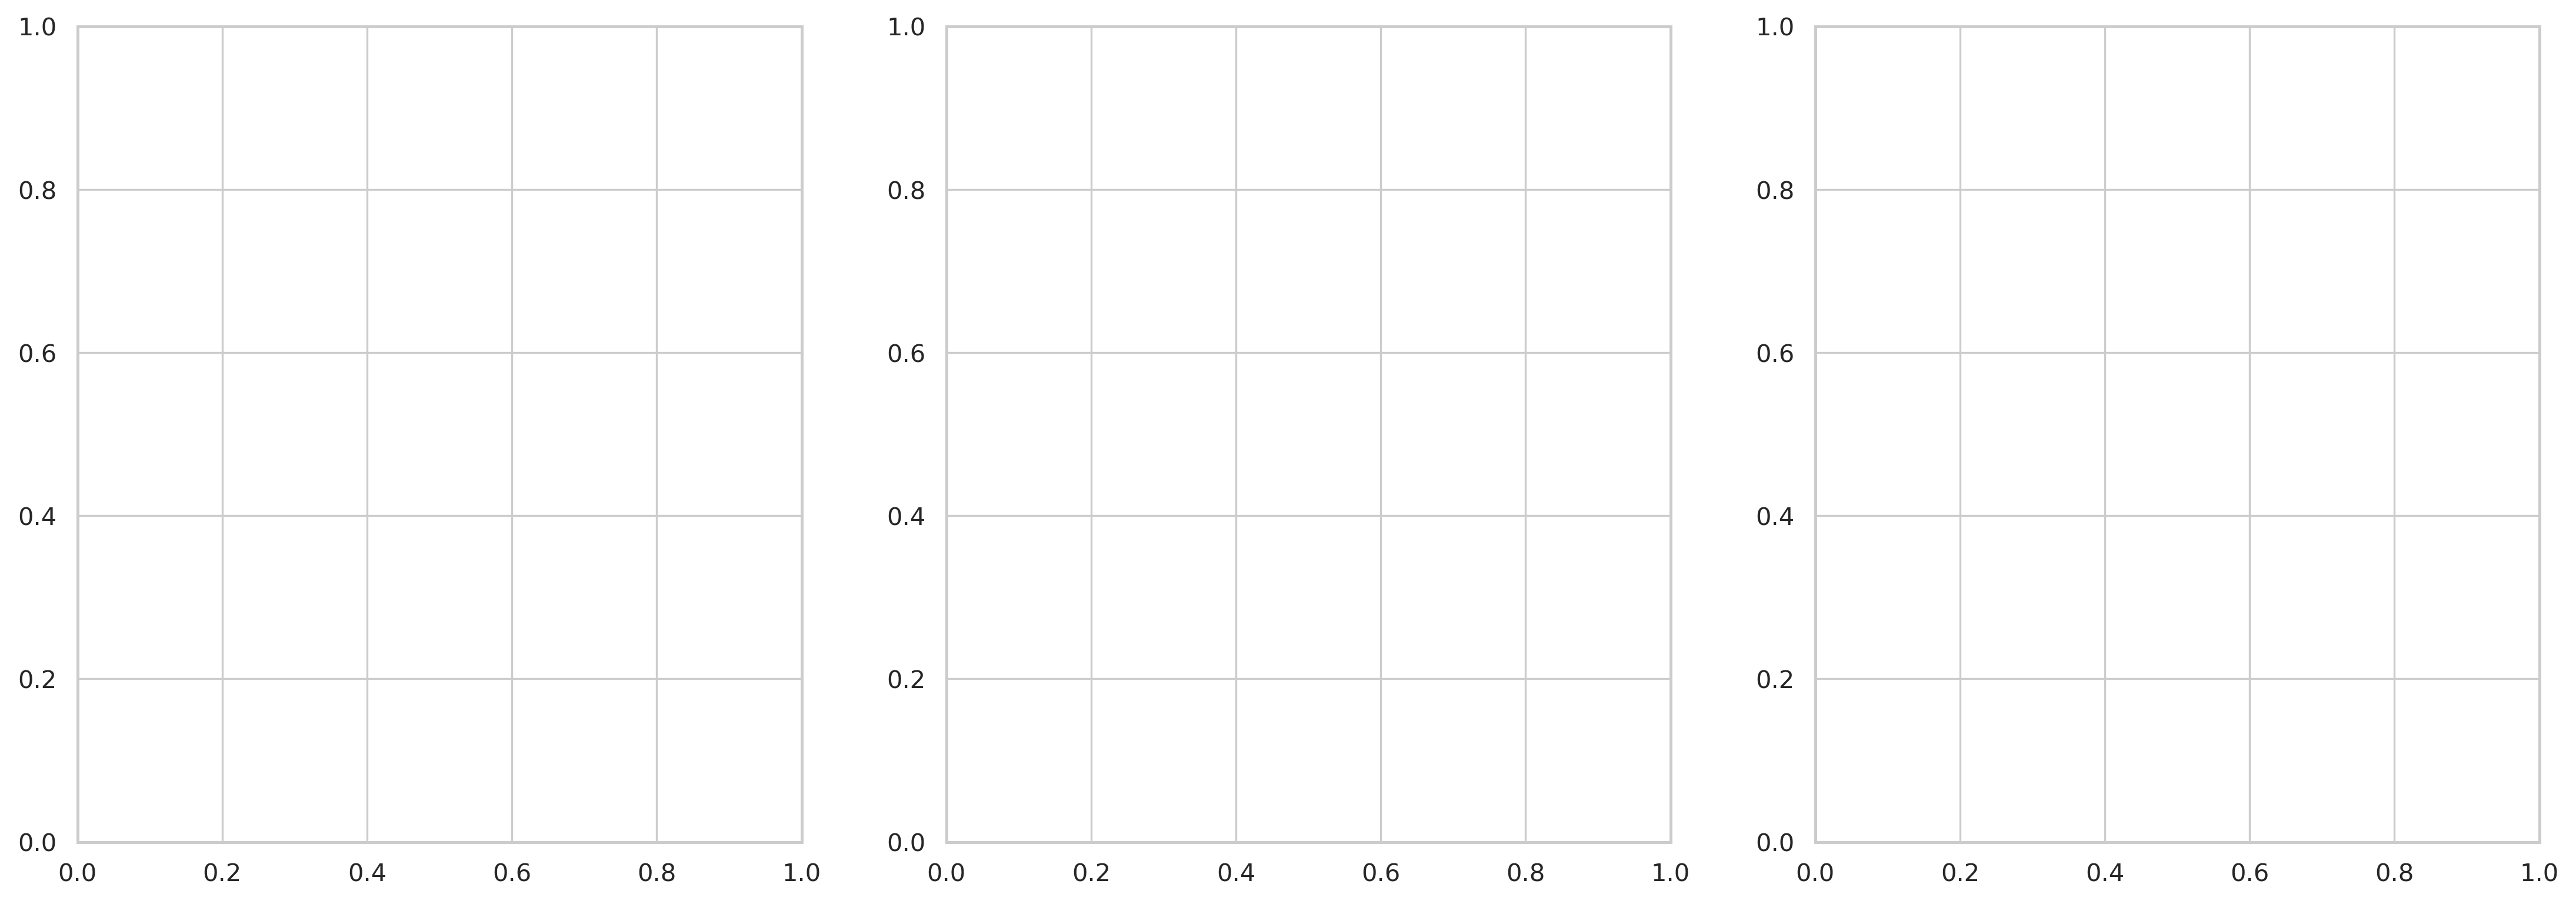

In [9]:
# setting figure dimensions slightly bigger for more breathing room between subplots 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

In [ ]:
# EXAMPLE: MLR vs. XGBRF Bland-Altman stats table 

#{'mean_diff': np.float64(-0.0003330735927080015),
# 'sd': np.float64(0.1748811557778685),
# 'ci_low': np.float64(-0.34310013891733027),
# 'ci_high': np.float64(0.34243399173191424),
# 'pct_within_limits': np.float64(94.656007421454),
# 'proportional_bias_r': np.float64(0.1450640326529128),
# 'proportional_bias_p': np.float64(0.0)}

bland_altman_plot(mlr_y_pred, xgbrf_y_pred, axes[0], 'MLR', 'XGBRF', confidence_interval=1.96)


{'mean_diff': np.float64(-0.0003330735927080015),
 'sd': np.float64(0.1748811557778685),
 'ci_low': np.float64(-0.34310013891733027),
 'ci_high': np.float64(0.34243399173191424),
 'pct_within_limits': np.float64(94.656007421454),
 'proportional_bias_r': np.float64(0.1450640326529128),
 'proportional_bias_p': np.float64(0.0)}


Generating 3 Bland-Altman plots for pairwise comparisons...
  Comparing MLR vs XGBRFRegressor...
  Comparing MLR vs RNN...
  Comparing XGBRFRegressor vs RNN...

Figure 3 saved to figure3(centered).png


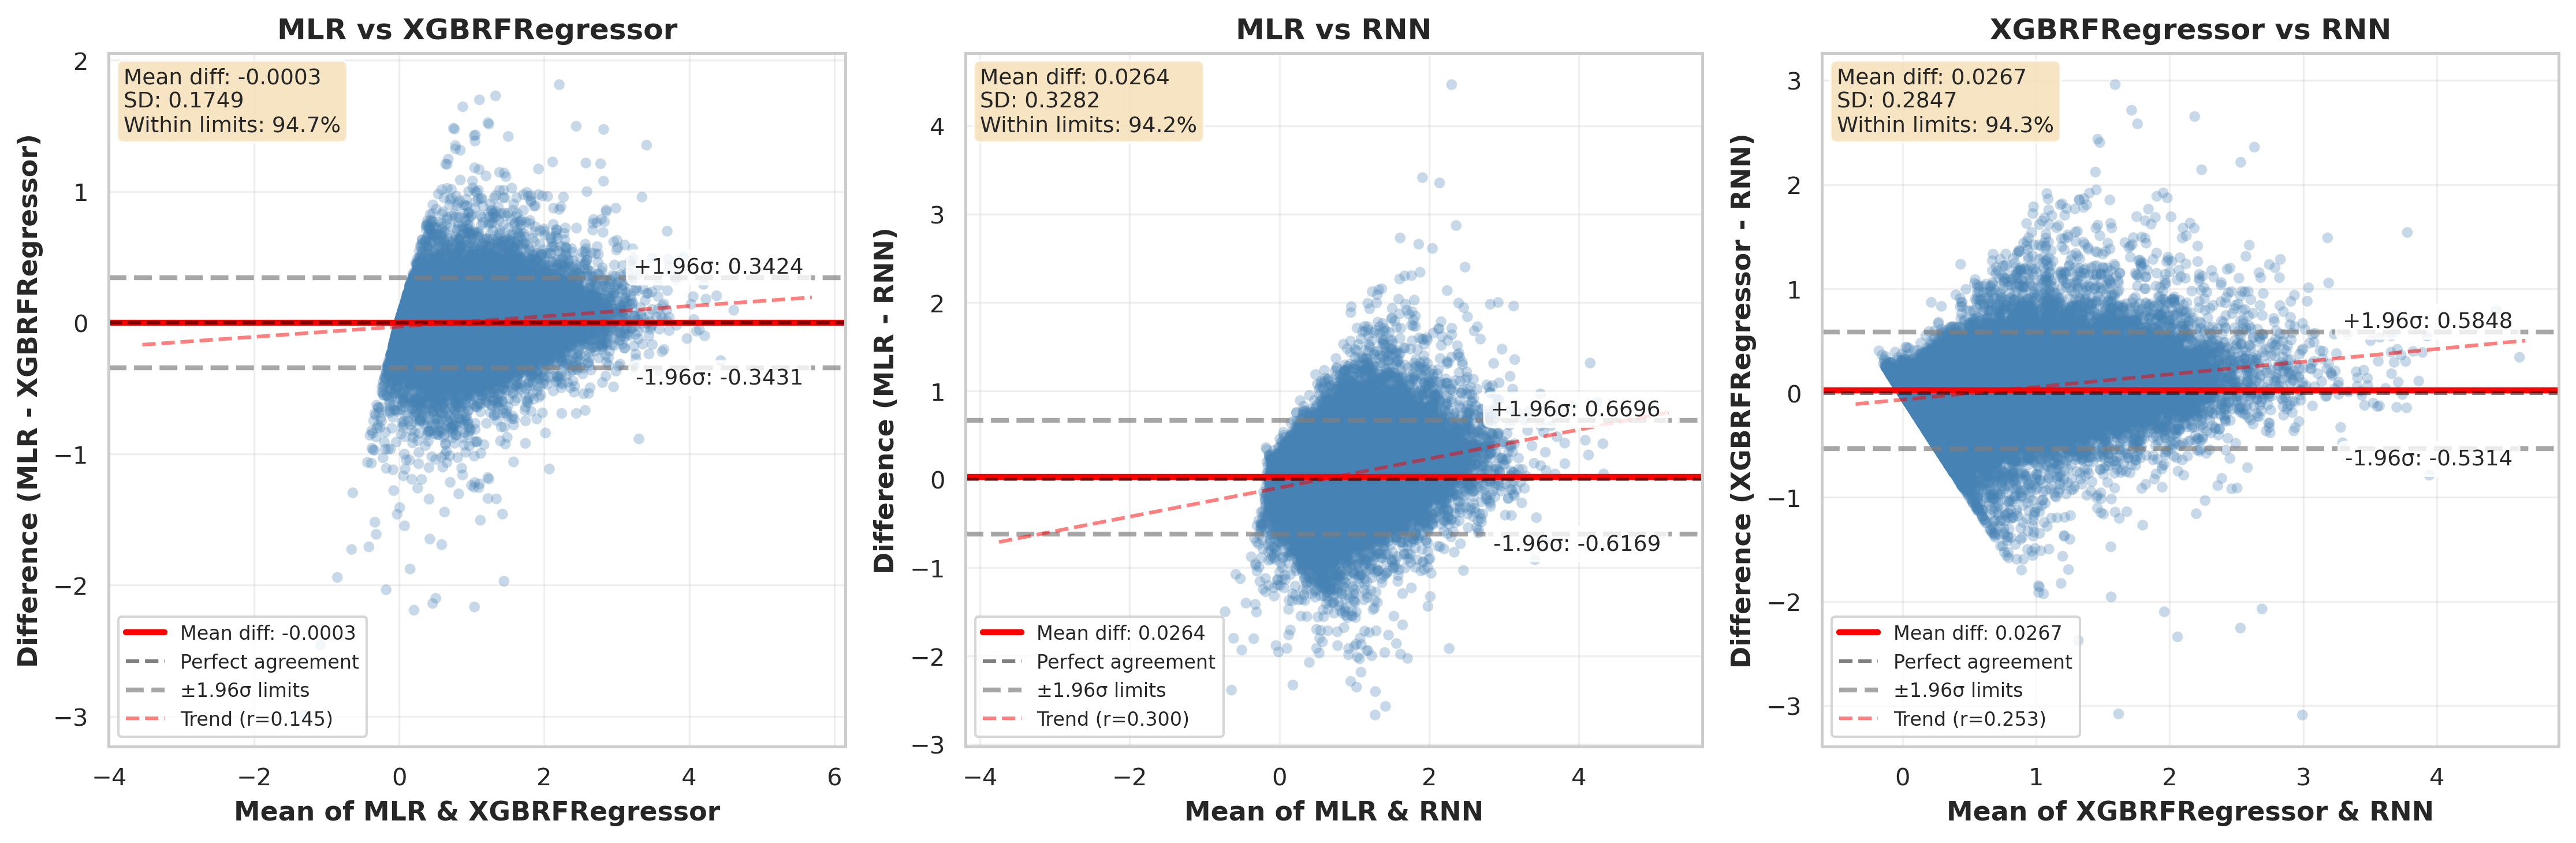


BLAND-ALTMAN COMPARISON SUMMARY

MLR_vs_XGBRFRegressor:
  Mean difference:  -0.0003
  SD of difference:  0.1749
  95% limits: [-0.3431,  0.3424]
  Within limits:  94.7%
  ⚠ Proportional bias: r=0.145, p=0.00e+00
  → Models show excellent agreement (negligible bias)

MLR_vs_RNN:
  Mean difference:   0.0264
  SD of difference:  0.3282
  95% limits: [-0.6169,  0.6696]
  Within limits:  94.2%
  ⚠ Proportional bias: r=0.300, p=0.00e+00
  → Models show good agreement (minor bias)

XGBRFRegressor_vs_RNN:
  Mean difference:   0.0267
  SD of difference:  0.2847
  95% limits: [-0.5314,  0.5848]
  Within limits:  94.3%
  ⚠ Proportional bias: r=0.253, p=0.00e+00
  → Models show good agreement (minor bias)



{'MLR_vs_XGBRFRegressor': {'mean_diff': np.float64(-0.0003330735927080015),
  'sd': np.float64(0.1748811557778685),
  'ci_low': np.float64(-0.34310013891733027),
  'ci_high': np.float64(0.34243399173191424),
  'pct_within_limits': np.float64(94.656007421454),
  'proportional_bias_r': np.float64(0.1450640326529128),
  'proportional_bias_p': np.float64(0.0)},
 'MLR_vs_RNN': {'mean_diff': np.float64(0.026383294689961066),
  'sd': np.float64(0.3281856791639949),
  'ci_low': np.float64(-0.6168606364714689),
  'ci_high': np.float64(0.669627225851391),
  'pct_within_limits': np.float64(94.23971023587673),
  'proportional_bias_r': np.float64(0.2998076257048331),
  'proportional_bias_p': np.float64(0.0)},
 'XGBRFRegressor_vs_RNN': {'mean_diff': np.float32(0.026716366),
  'sd': np.float32(0.2847462),
  'ci_low': np.float32(-0.5313862),
  'ci_high': np.float32(0.5848189),
  'pct_within_limits': np.float64(94.3011399181847),
  'proportional_bias_r': np.float32(0.25256488),
  'proportional_bias_p':

In [ ]:
# MLR vs. XGBRF Bland-Altman plot and summary stats 
figure_3_bland_altman(predictions, 'figure3_(PRODUCTION)).png')

In [ ]:
# MLR vs. RNN
bland_altman_plot(mlr_y_pred, rnn_y_pred, axes[1], 'MLR', 'RNN', confidence_interval=1.96)

In [ ]:
# XGBRF vs. RNN
bland_altman_plot(xgbrf_y_pred, rnn_y_pred, axes[2], 'XGBRF', 'RNN', confidence_interval=1.96)

In [ ]:
plt.tight_layout()
plt.show()